# Understanding the differences to identify customer segments <img align='right' width='90' height='130' src='https://maiseducativa.com/wp-content/uploads/2015/02/Logo_Nova-IMS.jpg'>

## <font color='SeaGreen'>__Data Description__</font><br>

**Business Challange: understanding the differences to identify customer segments**

**Input:** 
    
Dataset

**First Policy:** Year of the customer’s first policy 
- May be considered as the first year as a customer

**Birthday:** Customer’s Birthday Year 
- The current year of the database is 2016

**Education:** Academic Degree

**Salary:** Gross monthly salary (€)

**Area:** Living area 
- No further information provided about the meaning of the area codes

**Children:** Binary variable (Y=1)

**CMV:** Customer Monetary Value 
- Lifetime value = (annual profit from the customer) X (number of years that they are  a customer)-(acquisition cost)

**Claims:** Claims Rate 
- Amount paid by the insurance company (€)/ Premiums (€) Note: in the last 2 years

**Motor:** Premiums (€) in LOB: Motor 
- Annual Premiums (2016). Negative premiums may manifest reversals occurred in the current year, paid in previous one(s).

**Household:** Premiums (€) in LOB: Household 
- Annual Premiums (2016). Negative premiums may manifest reversals occurred in the currentyear, paid in previous one(s).

**Health:** Premiums (€) in LOB: Health
- Annual Premiums (2016). Negative premiums may manifest reversals occurred in the current year, paid in previous one(s).

**Life:** Premiums (€) in LOB: Life 
- Annual Premiums (2016). Negative premiums may manifest reversals occurred in the current year, paid in previous one(s).

**Work Compensation:** Premiums (€) in LOB: Work Compensations 
- Annual Premiums (2016). Negative premiums may manifest reversals occurred in the current year, paid in previous one(s).

**Output**

A report with the informations below.

**1.** Explore the data and identify the variables that should be used to segment customers.

**2.** Identify customer segments

**3.** Justify the number of clusters you chose (taking in consideration the business use as well).

**4.** Explain the clusters found.

**5.** Suggest business applications for the findings and define general marketing approaches for each cluster.

# <font color='SeaGreen'>0.0. Imports </font>
Libraries, data file path, and importing of the data

In [332]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import scipy.stats as stats

from sklearn.neural_network import MLPClassifier, MLPRegressor

from math import ceil
from matplotlib import pyplot as plt
from IPython.display import Image, HTML
from datetime import datetime
from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import os
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
from sklearn import ensemble as en
from sklearn import mixture as mx
from scipy.cluster import hierarchy as hc

from sklearn import decomposition as dd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
from matplotlib import cm
from matplotlib import colors

## <font color='SeaGreen'>0.1. Helper Functions </font>

In [333]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [334]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

## <font color='SeaGreen'>0.2. Load dataset </font>

In [466]:
# Dataset
dataset = pd.read_sas('a2z_insurance.sas7bdat')

# Convert Dataset to DataFrame
DF = pd.DataFrame (dataset)

# Set index
#DF.set_index('CustID', inplace=True, drop=True)

# Checking data import
#display(DF.head(2))

# <font color='SeaGreen'>1.0. Data Description </font>

In [467]:
df1 = DF.copy()
df1 = df1.drop(columns = ['CustID'])
df1.head(2)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13


## <font color='SeaGreen'>1.1. Data dimensions </font>

In [468]:
print('DataFrame Dimensions:')
print('- Number of Rows: {}'.format(df1.shape[0]))
print('- Number of Columns: {}'.format(df1.shape[1]))

DataFrame Dimensions:
- Number of Rows: 10296
- Number of Columns: 13


## <font color='SeaGreen'>1.2. Data types </font>

In [469]:
df1.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [470]:
df1.Children = df1.Children.astype("boolean") 

In [471]:
df1['EducDeg'].unique()

array([b'2 - High School', b'1 - Basic', b'3 - BSc/MSc', b'4 - PhD', nan],
      dtype=object)

In [472]:
df1['EducDeg'] = df1['EducDeg'].apply( lambda x: 'High_School' if x==b'2 - High School'
                                      else 'Basic' if x== b'1 - Basic'
                                      else 'BSc_MSc' if x== b'3 - BSc/MSc'
                                      else 'PhD' if x == b'4 - PhD'
                                      else 'nan')


In [473]:
df1['EducDeg'].unique()

array(['High_School', 'Basic', 'BSc_MSc', 'PhD', 'nan'], dtype=object)

## <font color='SeaGreen'>1.3. Check NA </font>

In [474]:
def missing_value_reporter(data, threshold=None):
    '''
    Returns pandas dataframe with feature's missing values count in absolute and relative frequency
    after a threshold is parsed (max % of column missing values), so it'll tell if the features are 
    above or bellow the desired missing threshold limit (True for above or False for bellow).
    
    If the threshold is not provided, it defaults to None.
     Args:
        data - input for data
        threshold - input for threshold variable from 0 to 1
        
    '''
    na_count = data.isna().sum() 
    na_count = na_count[na_count > 0]
    na_abs_frq = na_count.values
    na_rel_frq = round(na_count/len(data),3)
    missings = pd.DataFrame({'Feature': na_count.index, 'Nº of missings': na_abs_frq, '% of missings': na_rel_frq})
    missings = missings.sort_values(by = 'Nº of missings', ascending = False)
    
    if threshold:
        missings['Above threshold'] = [True if x > threshold else False for x in missings['% of missings']]
        
    return missings

In [475]:
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df1.dtypes).T.rename(index={0:'Column type'})
tab_info=tab_info.append(pd.DataFrame(df1.isnull().sum()).T.rename(index={0:'Count for null values'}))
tab_info=tab_info.append(pd.DataFrame(df1.isnull().sum()/df1.shape[0]*100).T.
                         rename(index={0:'Null values (%)'}))
display(tab_info)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
Column type,float64,float64,object,float64,float64,boolean,float64,float64,float64,float64,float64,float64,float64
Count for null values,30,17,0,36,1,21,0,0,34,0,43,104,86
Null values (%),0.291375,0.165113,0.0,0.34965,0.009713,0.203963,0.0,0.0,0.330225,0.0,0.417638,1.010101,0.835276


In [476]:
missing_value_reporter(df1, threshold=None)

,Feature,Nº of missings,% of missings
PremLife,PremLife,104,0.010
PremWork,PremWork,86,0.008
PremHealth,PremHealth,43,0.004
MonthSal,MonthSal,36,0.003
PremMotor,PremMotor,34,0.003
FirstPolYear,FirstPolYear,30,0.003
Children,Children,21,0.002
BirthYear,BirthYear,17,0.002
GeoLivArea,GeoLivArea,1,0.000


## <font color='SeaGreen'>1.4. Replace NA </font>

In [477]:
# remove na
df1 = df1.dropna(subset = ['PremLife','PremWork','PremHealth','MonthSal','PremMotor','FirstPolYear','Children','BirthYear','EducDeg','GeoLivArea'])
print('Removed data:{:.2f}'.format (1-(df1.shape[0]/dataset.shape[0])))

Removed data:0.03


In [478]:
df1.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [479]:
print('\nNumber of rows of initial dataset is', dataset.shape[0])
print('\nNumber of rows of DF, after cleaning NAN and Duplicate valeus is', df1.shape[0])
print('\nNumber of rows cleaned is', dataset.shape[0]-df1.shape[0])


Number of rows of initial dataset is 10296

Number of rows of DF, after cleaning NAN and Duplicate valeus is 9987

Number of rows cleaned is 309


## <font color='SeaGreen'>1.5. Duplicated Values </font>

In [480]:
df1.duplicated().sum()

3

### <font color='SeaGreen'>1.5.1. Remove Duplicated Values </font>

In [481]:
df1 = df1.drop_duplicates()

In [482]:
df1.duplicated().sum()

0

In [483]:
print('\nNumber of rows of initial dataset is', dataset.shape[0])
print('\nNumber of rows of DF, after cleaning NAN valeus is', df1.shape[0])
print('\nNumber of rows cleaned is', dataset.shape[0]-df1.shape[0])


Number of rows of initial dataset is 10296

Number of rows of DF, after cleaning NAN valeus is 9984

Number of rows cleaned is 312


## <font color='SeaGreen'>1.6. Descriptive Statistics </font>

In [484]:
df1.describe(include="all").T 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FirstPolYear,9984.0,NaN,NaN,NaN,1991.211538,518.436721,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,9984.0,NaN,NaN,NaN,1968.019531,19.810646,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,9984,4,BSc_MSc,4645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,9984.0,NaN,NaN,NaN,2505.733974,1164.222865,333.0,1699.75,2501.0,3293.0,55215.0
GeoLivArea,9984.0,NaN,NaN,NaN,2.713842,1.266678,1.0,1.0,3.0,4.0,4.0
Children,9984,2,True,7044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustMonVal,9984.0,NaN,NaN,NaN,177.850838,1975.52651,-165680.42,-8.21,187.875,399.8875,11875.89
ClaimsRate,9984.0,NaN,NaN,NaN,0.745387,2.961171,0.0,0.39,0.72,0.98,256.2
PremMotor,9984.0,NaN,NaN,NaN,298.976092,213.39232,-4.11,189.59,297.39,406.3,11604.42
PremHousehold,9984.0,NaN,NaN,NaN,212.980369,356.154097,-75.0,50.0,133.9,294.5,25048.8


## <font color='SeaGreen'>1.7. Data Exploration </font>
Correlations with data, plotting of correlations, hypothesizing.

In [485]:
df1.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FirstPolYear,9984.0,NaN,NaN,NaN,1991.211538,518.436721,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,9984.0,NaN,NaN,NaN,1968.019531,19.810646,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,9984,4,BSc_MSc,4645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,9984.0,NaN,NaN,NaN,2505.733974,1164.222865,333.0,1699.75,2501.0,3293.0,55215.0
GeoLivArea,9984.0,NaN,NaN,NaN,2.713842,1.266678,1.0,1.0,3.0,4.0,4.0
Children,9984,2,True,7044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustMonVal,9984.0,NaN,NaN,NaN,177.850838,1975.52651,-165680.42,-8.21,187.875,399.8875,11875.89
ClaimsRate,9984.0,NaN,NaN,NaN,0.745387,2.961171,0.0,0.39,0.72,0.98,256.2
PremMotor,9984.0,NaN,NaN,NaN,298.976092,213.39232,-4.11,189.59,297.39,406.3,11604.42
PremHousehold,9984.0,NaN,NaN,NaN,212.980369,356.154097,-75.0,50.0,133.9,294.5,25048.8


In [486]:
'''
Insights from the descriptive statistics above:
1) FirstPolYear goes from 1974 to 53784, clearly there's something wrong with this max value. 
2) BirthYear has a minimum of 1028 and a maximum of 2001. This is a large range. There is something wrong with our minimum value
3) GeoLivArea ranges from 1 to 4
4) Children is binary
5) CustMonVal can be negative and very much possible if the annual profit 
from the customer is negative.
6) ClaimsRate goes from 0 to 256.20. The maximum value doesnt make a lot of sense considering the third quartile, however 
its not impossible
7) PremMotor, PremHousehold, PremHealth, PremLife, PremWork can all have negative values, resulting from reversals occured
8) Other features are more difficult to interpret from the descriptive stats above.
'''

"\nInsights from the descriptive statistics above:\n1) FirstPolYear goes from 1974 to 53784, clearly there's something wrong with this max value. \n2) BirthYear has a minimum of 1028 and a maximum of 2001. This is a large range. There is something wrong with our minimum value\n3) GeoLivArea ranges from 1 to 4\n4) Children is binary\n5) CustMonVal can be negative and very much possible if the annual profit \nfrom the customer is negative.\n6) ClaimsRate goes from 0 to 256.20. The maximum value doesnt make a lot of sense considering the third quartile, however \nits not impossible\n7) PremMotor, PremHousehold, PremHealth, PremLife, PremWork can all have negative values, resulting from reversals occured\n8) Other features are more difficult to interpret from the descriptive stats above.\n"

In [487]:
df1.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         boolean
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [488]:
##Define metric and non-metric features. 
non_metric_features = ["EducDeg", "Children"]
metric_features = df1.columns.drop(non_metric_features).to_list()

### <font color='SeaGreen'>1.7.1. Univariate Analysis </font>

### <font color='SeaGreen'>FirstPolYear </font>

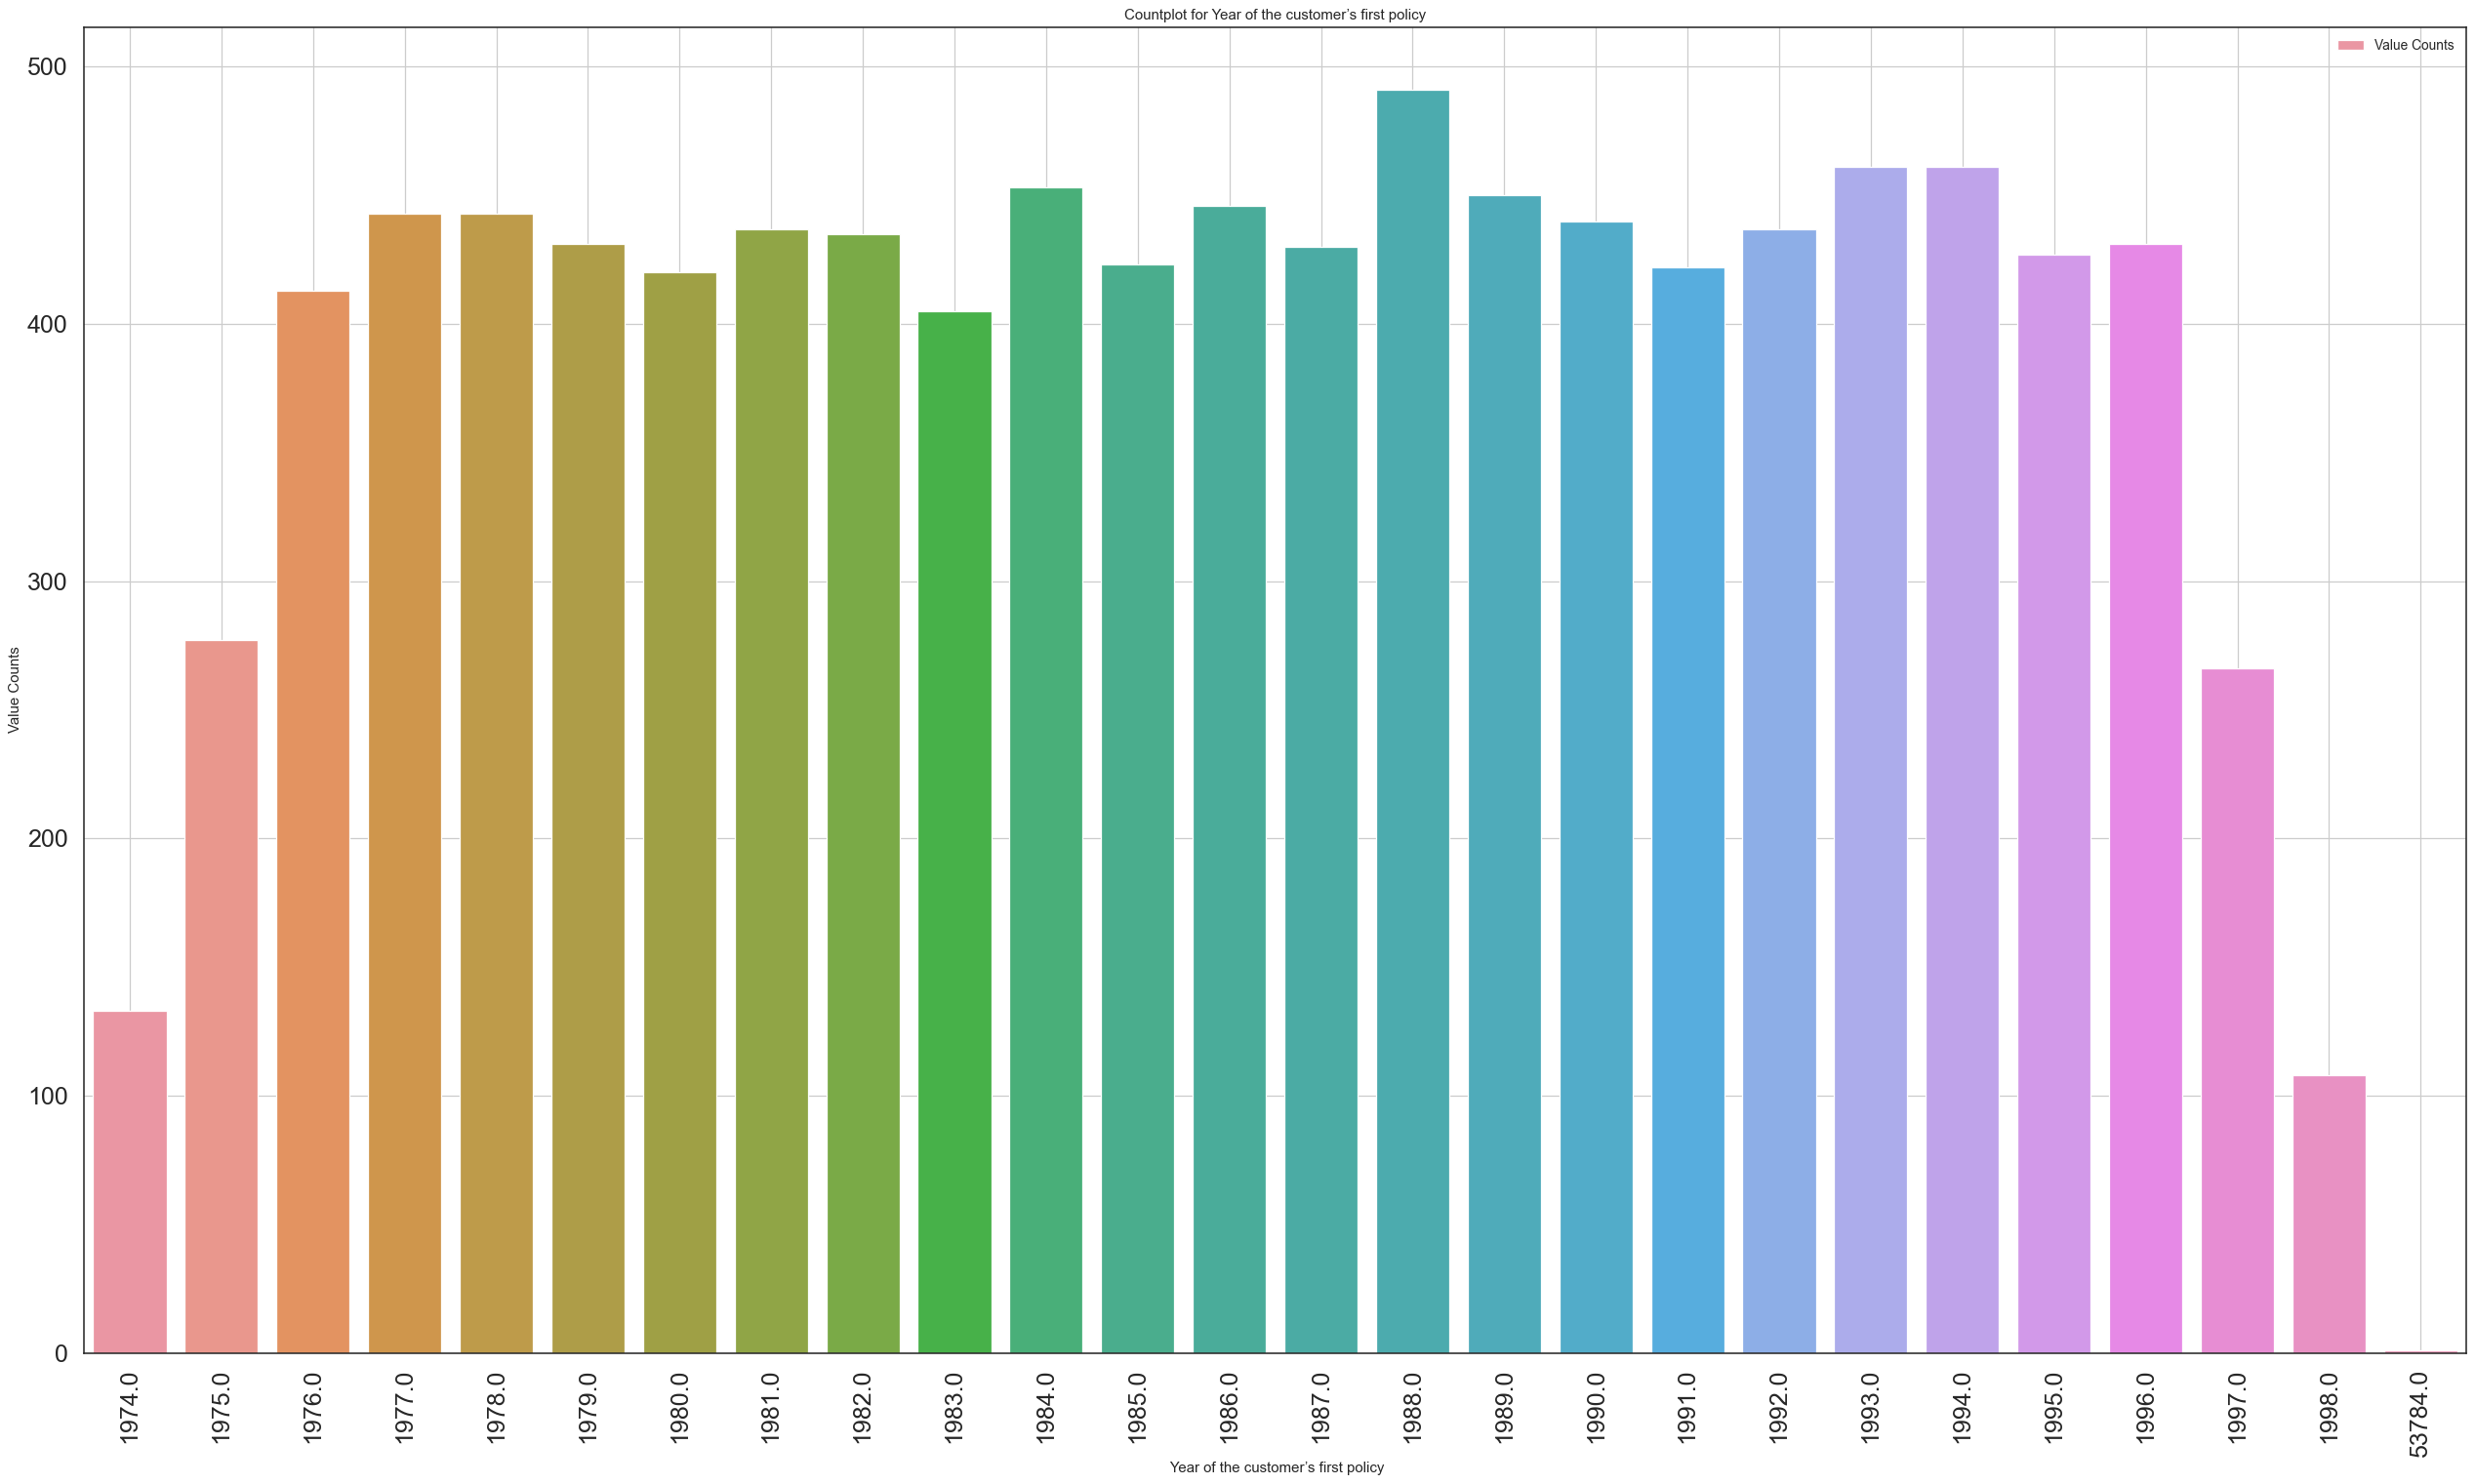

In [489]:
plt.figure (figsize = (35,20) , dpi = 90)
ax = sns.countplot (x  = 'FirstPolYear' , data = df1)
plt.xticks (rotation = 90 , fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel (' Year of the customer’s first policy')
plt.ylabel ('Value Counts')
plt.legend (['Value Counts'])
plt.title ('Countplot for Year of the customer’s first policy')
plt.grid()
plt.show ()

# 'FirstPolYear' has an uniform distribution
# For this column, the value=53784 is an outlier

In [490]:
# See which customer incorrectly inserted the outlier FirstYearPol=53784
df1.loc[df1['FirstPolYear'] == 53784]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
9294,53784.0,1948.0,BSc_MSc,3268.0,1.0,False,348.85,0.37,351.4,15.0,187.37,22.45,17.78


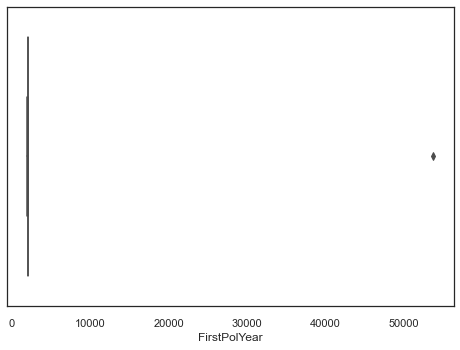

"\nThis boxplot shows that majority of customers' first year being customers for this insurance company is under 10000. The \nmaximum year on the dataset is more than 50000.\n"

In [491]:
sns.boxplot(df1['FirstPolYear'])
plt.show()

'''
This boxplot shows that majority of customers' first year being customers for this insurance company is under 10000. The 
maximum year on the dataset is more than 50000.
'''

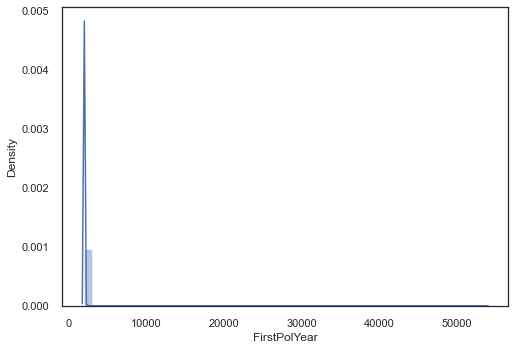

'\nThis is extremely right skewed distribution.\n'

In [492]:
# Plotting the distribution of the 2nd column of train dataset using Histogram:
sns.distplot(df1['FirstPolYear'])
plt.show()
'''
This is extremely right skewed distribution.
'''

### <font color='SeaGreen'>BirthYear </font>

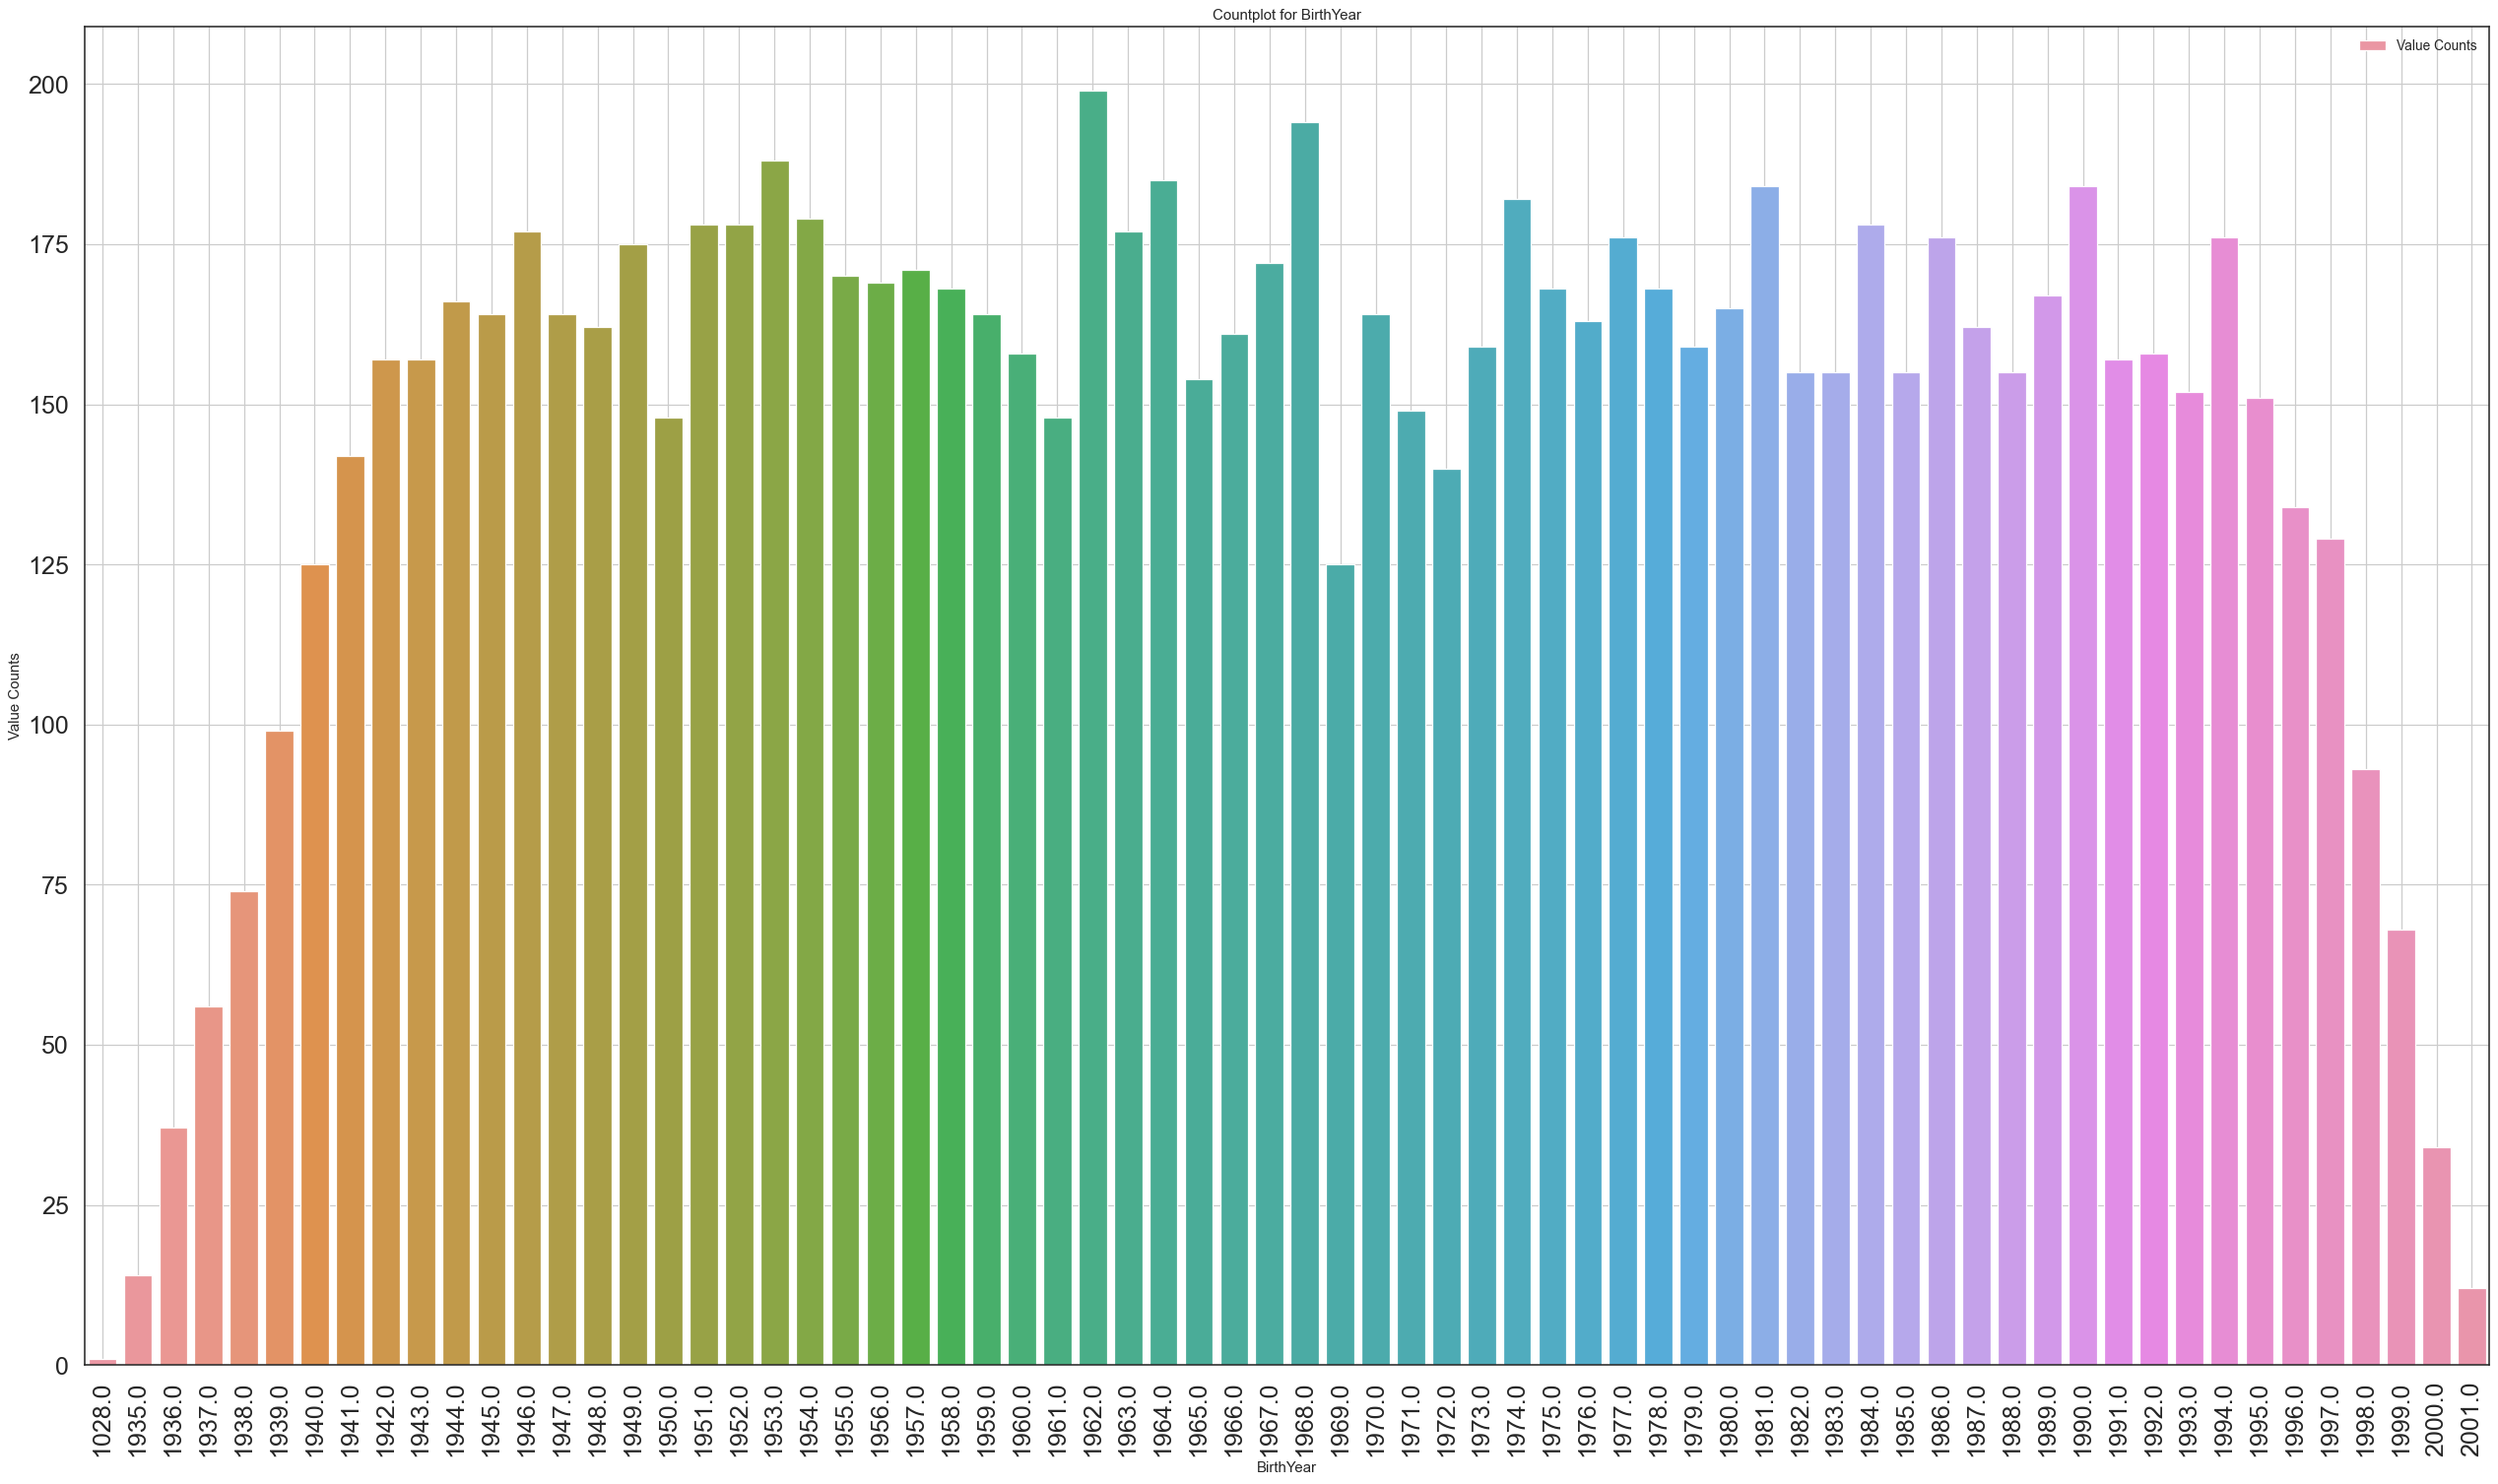

In [493]:
plt.figure (figsize = (35,20) , dpi = 90)
ax = sns.countplot (x  = 'BirthYear' , data = df1)
plt.xticks (rotation = 90 , fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel ('BirthYear', fontsize=12)
plt.ylabel ('Value Counts', fontsize=12)
plt.legend (['Value Counts'])
plt.title ('Countplot for BirthYear')
plt.grid()
plt.show ()

# 'BirthYear' has an uniform distribution?
# BirthYear=1028 is an outlier. Without it, the minimum value would be 1935, which is very much a realistic value.

In [494]:
# See which customer incorrectly inserted the outlier BirthYear=1028
df1.loc[DF['BirthYear'] == 1028]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
7195,1993.0,1028.0,BSc_MSc,2830.0,4.0,False,146.02,0.77,428.97,192.8,108.91,1.89,23.67


### <font color='SeaGreen'>MonthSal </font>

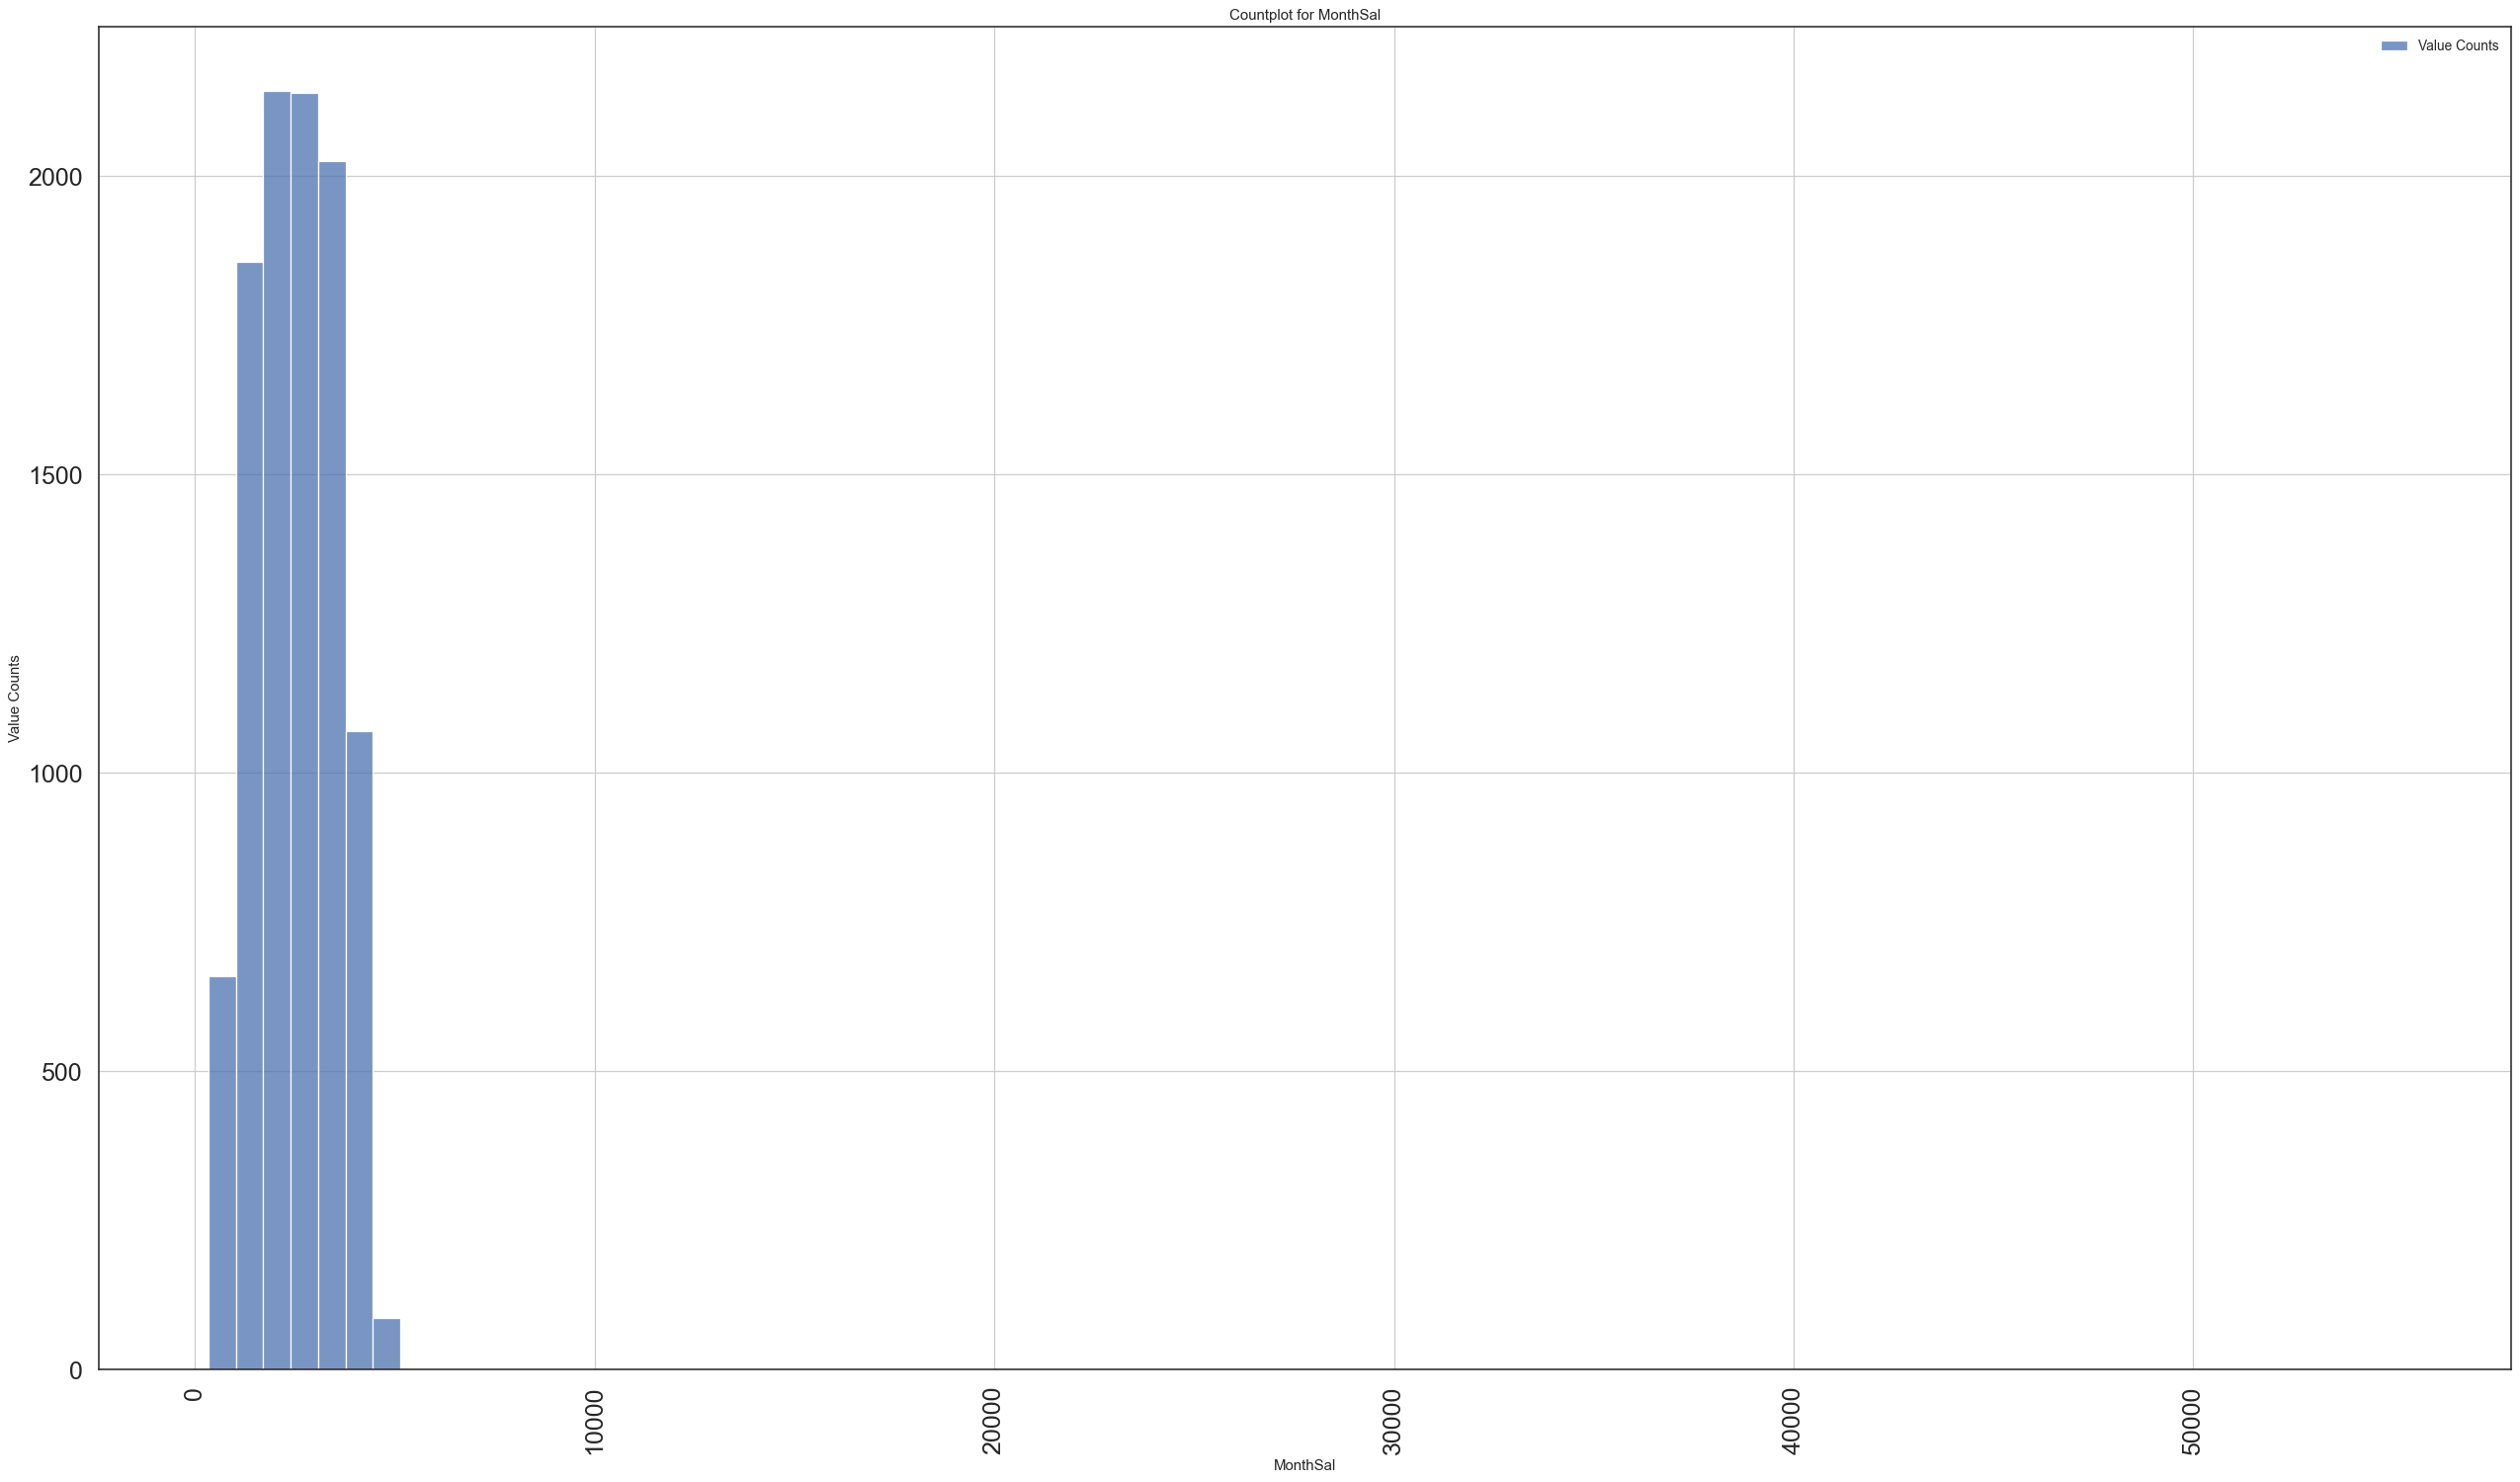

In [495]:
plt.figure (figsize = (35,20) , dpi = 90)
ax = sns.histplot(data=df1, x="MonthSal", bins=80)
plt.xticks (rotation = 90 , fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel ('MonthSal', fontsize=12)
plt.ylabel ('Value Counts', fontsize=12)
plt.legend (['Value Counts'])
plt.title ('Countplot for MonthSal')
plt.grid()
plt.show ()

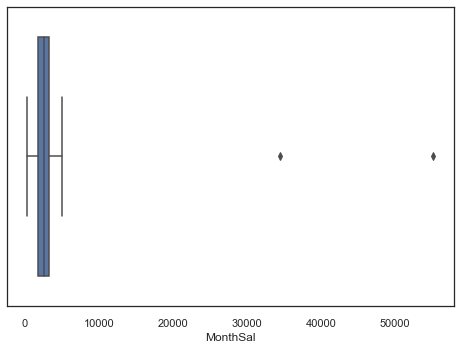

"\nThis boxplot shows that majority of customers' monthly salary is under 10000. The maximum year on the dataset is more than \n50000. There is one point whose monthly salary is between 30000 and 40000 on the plot.\n"

In [496]:
sns.boxplot(df1['MonthSal'])
plt.show()

'''
This boxplot shows that majority of customers' monthly salary is under 10000. The maximum year on the dataset is more than 
50000. There is one point whose monthly salary is between 30000 and 40000 on the plot.
'''

### <font color='SeaGreen'> ClaimsRate </font>

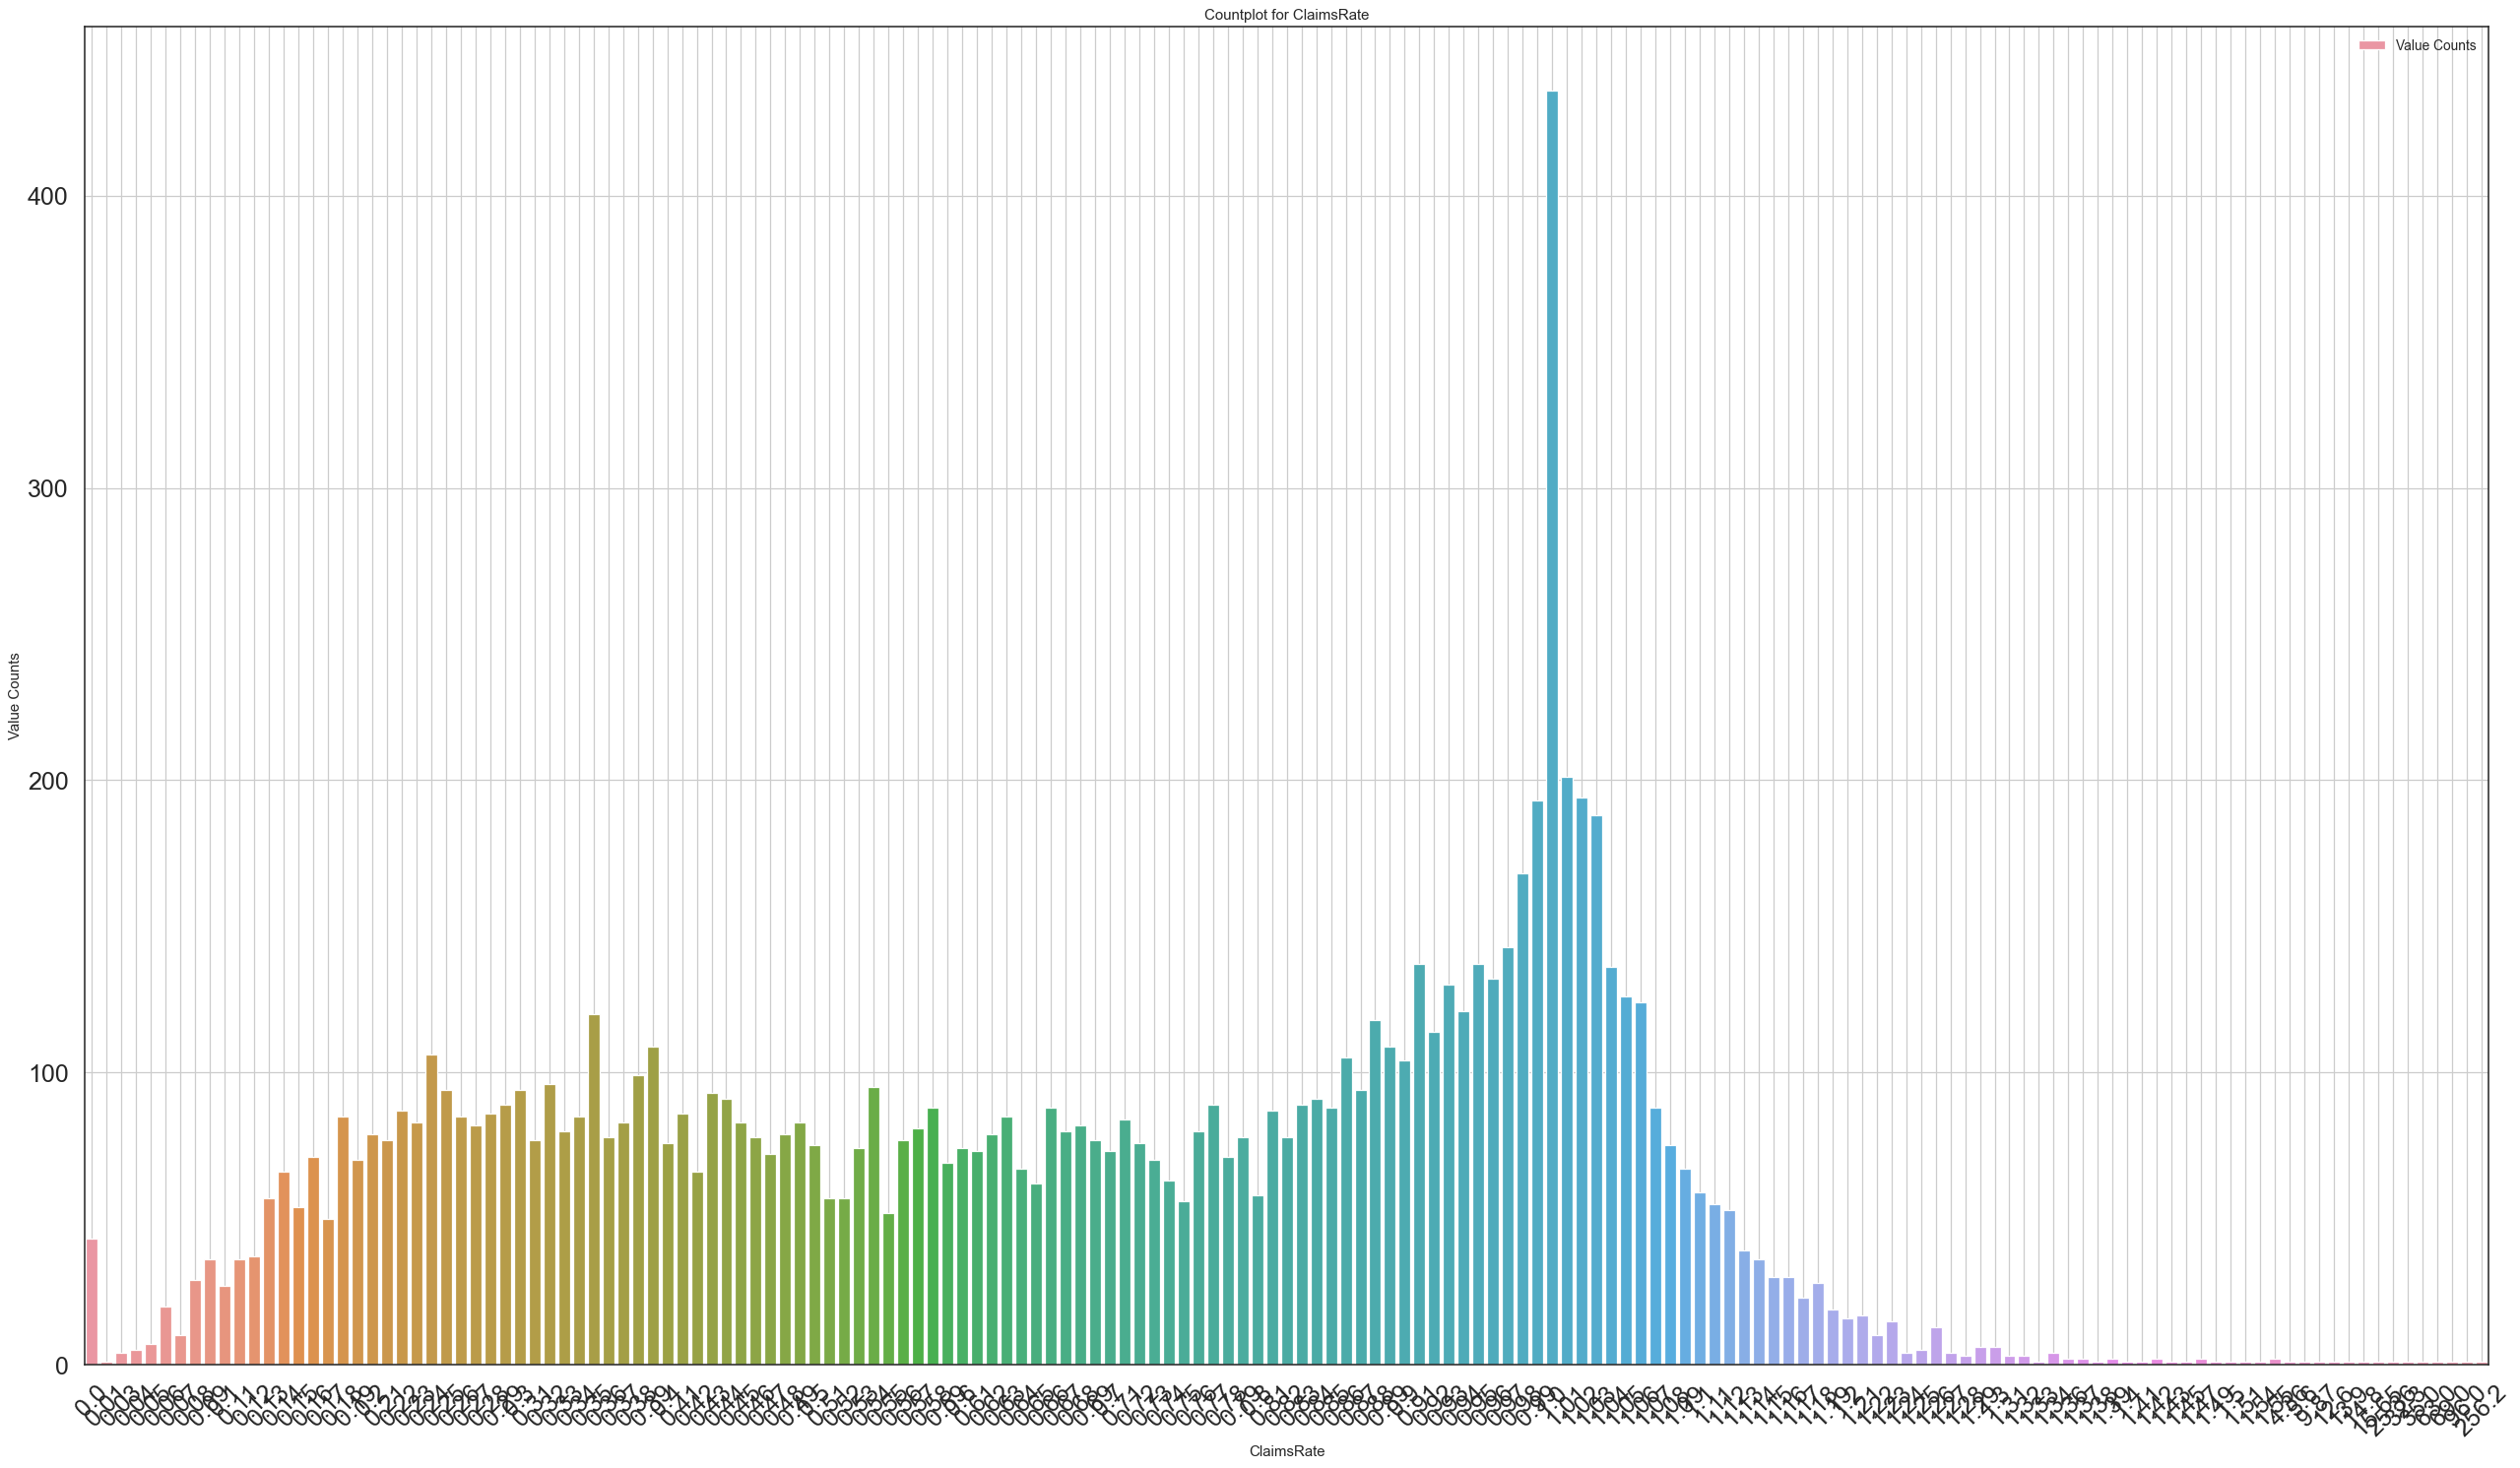

In [497]:
plt.figure (figsize = (35,20) , dpi = 90)
ax = sns.countplot (x  = 'ClaimsRate' , data = df1)
plt.xticks (rotation = 45 , fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel ('ClaimsRate')
plt.ylabel ('Value Counts')
plt.legend (['Value Counts'])
plt.title ('Countplot for ClaimsRate')
plt.grid()
plt.show ()

# 'ClaimsRate' has an uniform distribution?
# ClaimsRate does not seem to have outlier visible through a histogram

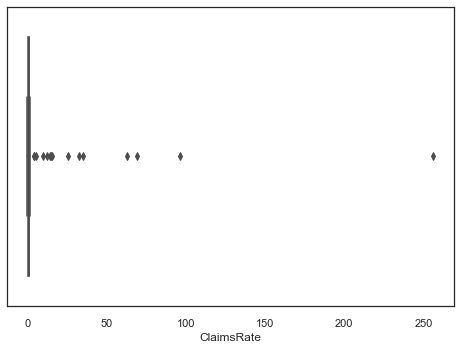

'\nThis boxplot shows that majority of customers get claims rate under 50. There are two points between 50 & 100 on \nthe plot and the maximum claims rate on the dataset is more than 250€.\n'

In [498]:
sns.boxplot(DF['ClaimsRate'])
plt.show()

'''
This boxplot shows that majority of customers get claims rate under 50. There are two points between 50 & 100 on 
the plot and the maximum claims rate on the dataset is more than 250€.
'''

## <font color='SeaGreen'>1.7.2. Bivariate Analysis </font>

### <font color='SeaGreen'> Pairplot </font>

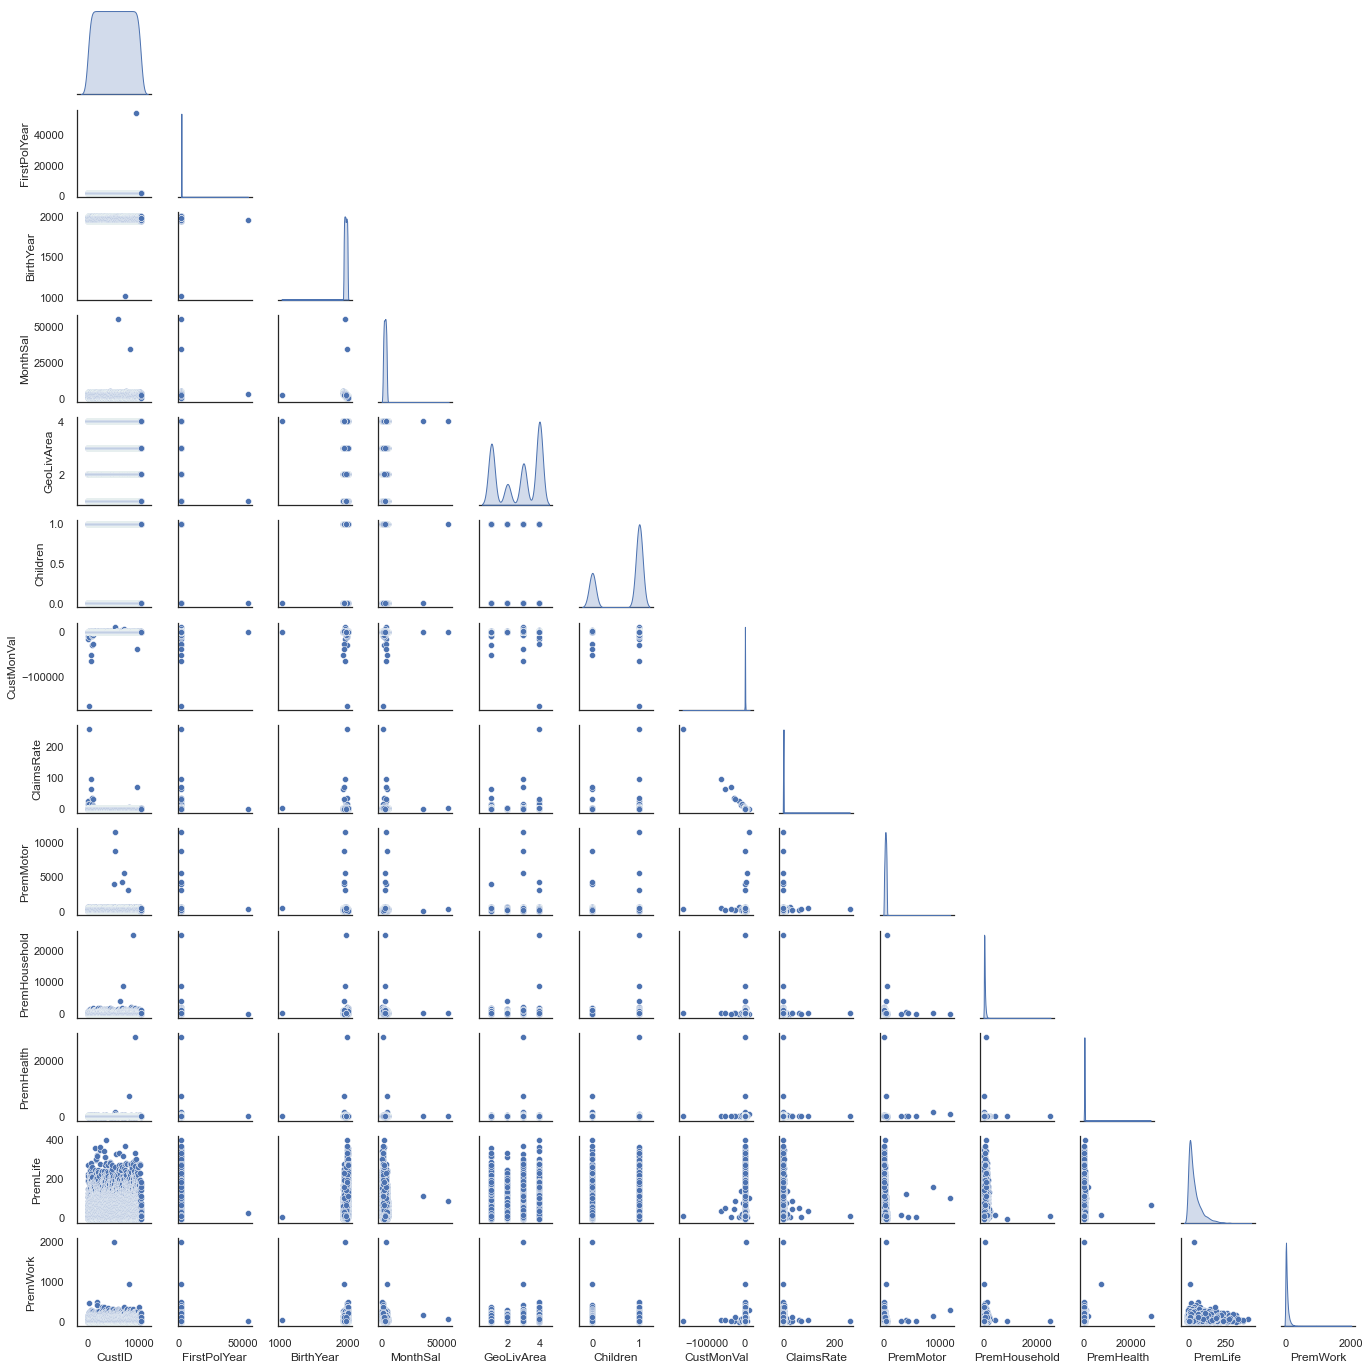

In [499]:
# Layout
plt.rcParams['font.size'] = '20'
# Plot
ax = sns.pairplot(DF, diag_kind = 'kde', corner = True, palette="green", height = 1.5)
plt.show()

### <font color='SeaGreen'>1.7.3. Numeric Variables

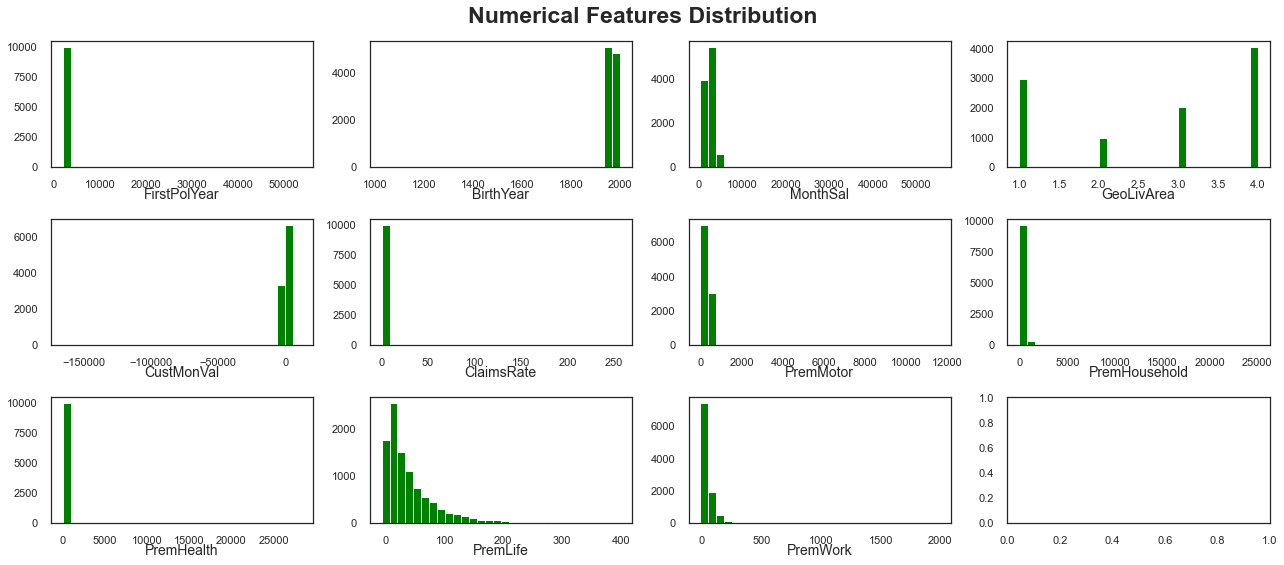

In [500]:
# All numeric features in one figure
sns.set_theme(style = 'white', palette = None)

# Selecting numeric features
numerical = df1.select_dtypes(include = ['float64', 'int64']).columns
        
# Plot
fig, axes = plt.subplots(nrows = 3, ncols = ceil(len(numerical)/3) , figsize = (18,8))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, col in zip(axes.flatten(), numerical): # Notice the zip() function and flatten() method
    ax.hist(df1[col], bins=30, color = 'green')
    ax.set_title(col.replace('_', ' '), y = -.30, fontsize=14)
    
# Layout
plt.suptitle('Numerical Features Distribution', fontsize = 23, fontweight = 'bold')
plt.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = 0.4, hspace = None) 

plt.tight_layout()

### <font color='SeaGreen'>1.7.4. Categorical Attributes</font>

### <font color='SeaGreen'> EducDeg  </font>

In [501]:
print(df1["EducDeg"].value_counts().sort_values(ascending = False))
print(f"The number of regions in our dataset is: {df1['EducDeg'].nunique()}")

BSc_MSc        4645
High_School    3426
Basic          1245
PhD             668
Name: EducDeg, dtype: int64
The number of regions in our dataset is: 4


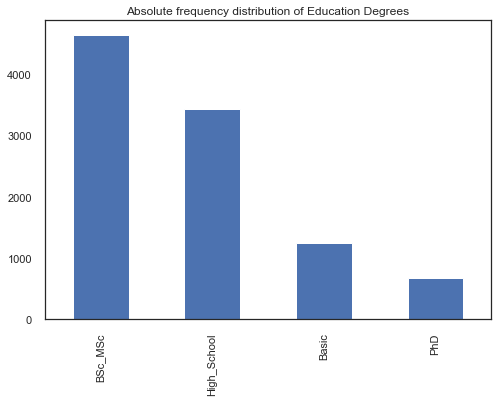

In [502]:
df1['EducDeg'].value_counts().plot(kind='bar', title='Absolute frequency distribution of Education Degrees');

### <font color='SeaGreen'> Correlation Matrix

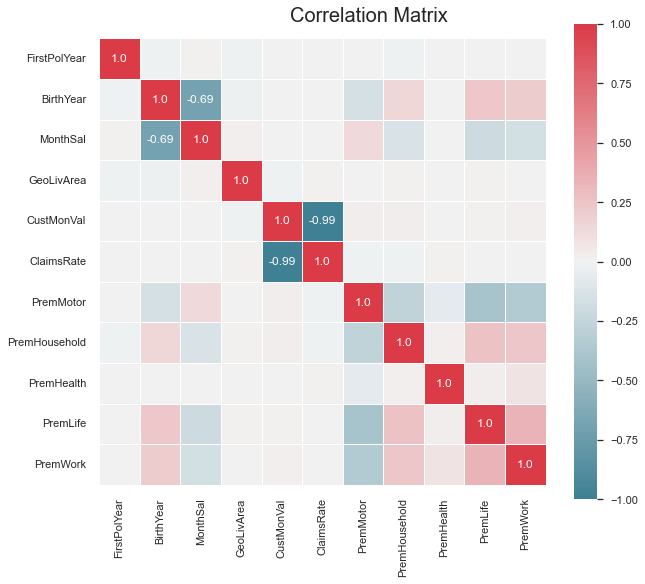

In [505]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df1[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.savefig(os.path.join('correlation_matrix.png'), dpi=200)

plt.show()

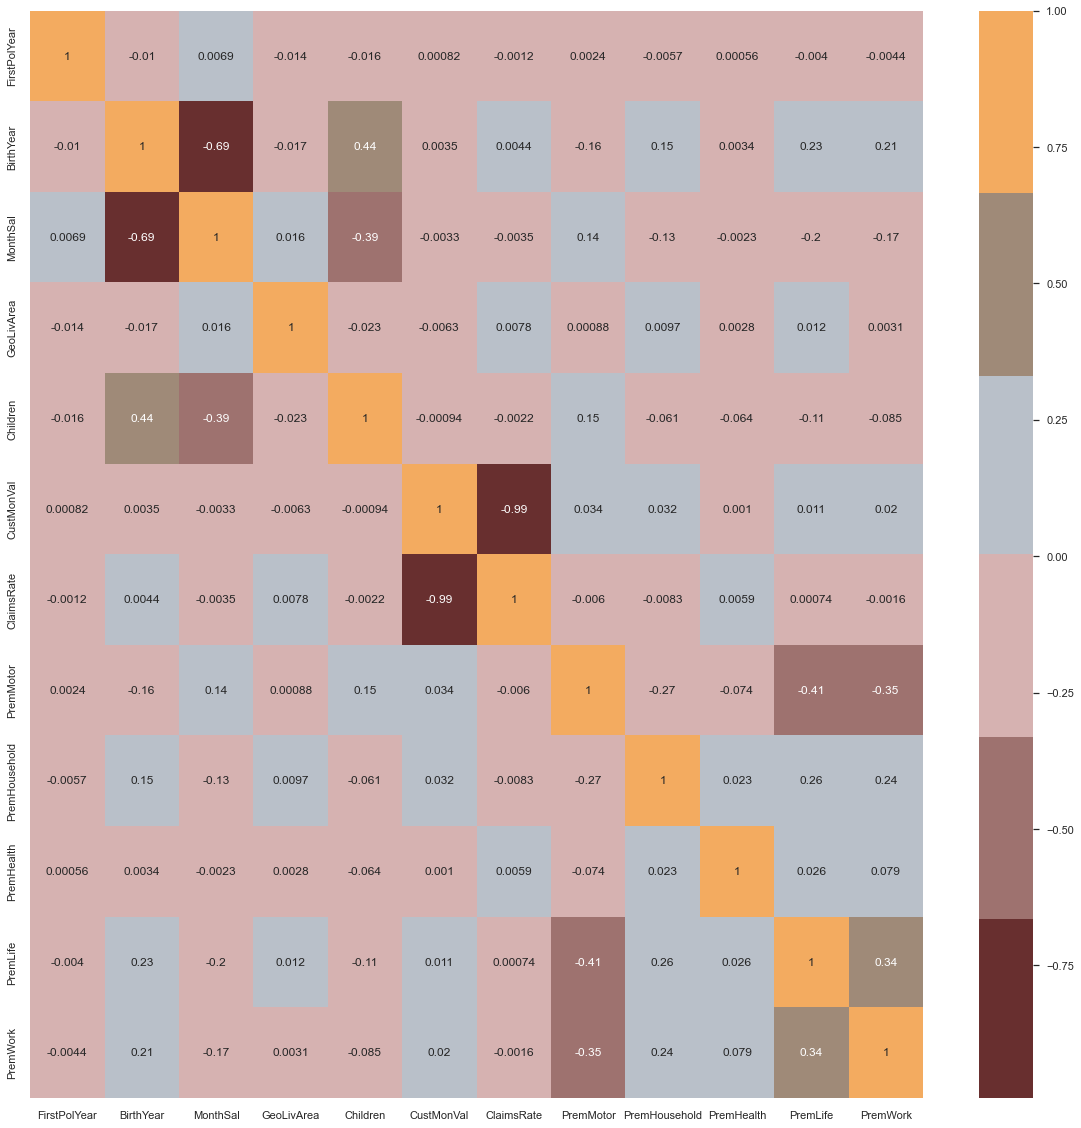

In [504]:
#correlation matrix
corrmat= df1.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0);

# <font color='SeaGreen'>2.0. Feature Engineering</font>

In [506]:
df2 = df1.copy()

### <font color='SeaGreen'> Age </font>

In [507]:
#Age of customer today 
df2["Age"] = 2016-df2["BirthYear"]
df2["Age"]

0        34.0
1        21.0
2        46.0
3        35.0
4        43.0
         ... 
10291    67.0
10292    64.0
10293    40.0
10294    39.0
10295    35.0
Name: Age, Length: 9984, dtype: float64

### <font color='SeaGreen'> Total premiums </font>

In [508]:
df2["Total_Prem"] = df2["PremMotor"]+ df2["PremHousehold"]+ df2["PremHealth"]+ df2["PremLife"]+ df2["PremWork"]
df2["Total_Prem"]

0         665.56
1         910.96
2         740.60
3         600.68
4         629.24
          ...   
10291     641.56
10292    1430.60
10293     696.24
10294     774.92
10295     669.56
Name: Total_Prem, Length: 9984, dtype: float64

In [509]:
'''
Insights:
- Apagar FirstPolYear uma vez que CustMonVal já inclui os anos que x pessoa é customer, ou seja quantos anos passaram desde 
essa data
- Ficam custid, age, academic degree, monthsal, geolivarea, children, custmonval, claimsrate-->Valpaidins, premiums
- relacionar custmonval eclaims rate. Será que os premiums= annual profit from the customer + cost of acquisition?? Se sim,
poder-se-á apagar uma destas variáveis

- premium por custmonval ou monthsal
'''

'\nInsights:\n- Apagar FirstPolYear uma vez que CustMonVal já inclui os anos que x pessoa é customer, ou seja quantos anos passaram desde \nessa data\n- Ficam custid, age, academic degree, monthsal, geolivarea, children, custmonval, claimsrate-->Valpaidins, premiums\n- relacionar custmonval eclaims rate. Será que os premiums= annual profit from the customer + cost of acquisition?? Se sim,\npoder-se-á apagar uma destas variáveis\n\n- premium por custmonval ou monthsal\n'

# 3.0. Data Filtering

In [510]:

df3=df2.copy()

In [511]:
df2.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,Total_Prem
0,1985.0,1982.0,High_School,2177.0,1.0,True,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34.0,665.56
1,1981.0,1995.0,High_School,677.0,4.0,True,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,21.0,910.96
2,1991.0,1970.0,Basic,2277.0,3.0,False,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46.0,740.60
3,1990.0,1981.0,BSc_MSc,1099.0,4.0,True,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35.0,600.68
4,1986.0,1973.0,BSc_MSc,1763.0,4.0,True,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43.0,629.24


## 3.1 Outliers

### 3.1.2. Removing Outliers 

In [512]:
# FirstPolYear
df3 = df3.loc[df3['FirstPolYear'] < 2000]
  
# BirthYear    
df3 = df3.loc[df3['BirthYear'] > 1029]

# 5.0. Data Preparation


## 5.1. Normalization

In [513]:
df5=df3.copy()
#Dropping some of the redundant features
to_drop = ['FirstPolYear',"BirthYear", "PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
df5 = df3.drop(to_drop, axis=1)
df5.head(1)

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,Age,Total_Prem
0,High_School,2177.0,1.0,True,380.97,0.39,34.0,665.56


In [514]:
##Define metric and non-metric features. 
non_metric_features = ["EducDeg", "Children"]
metric_features = df5.columns.drop(non_metric_features).to_list()

## MinMaxScaler

In [515]:
df_minmax = df5.copy()

In [516]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

array([[3.35993586e-02, 0.00000000e+00, 9.35260425e-01, 1.52224824e-03,
        2.87878788e-01, 6.99467363e-03],
       [6.26799315e-03, 1.00000000e+00, 9.32376270e-01, 4.37158470e-03,
        9.09090909e-02, 1.54955299e-02],
       [3.54214497e-02, 6.66666667e-01, 9.35957106e-01, 1.09289617e-03,
        4.69696970e-01, 9.59412048e-03],
       ...,
       [4.71010532e-02, 0.00000000e+00, 9.36066536e-01, 8.19672131e-04,
        3.78787879e-01, 8.05745387e-03],
       [2.98458511e-02, 3.33333333e-01, 9.34523082e-01, 2.53708041e-03,
        3.63636364e-01, 1.07829933e-02],
       [4.52242994e-02, 0.00000000e+00, 9.35726644e-01, 1.05386417e-03,
        3.03030303e-01, 7.13323689e-03]])

In [517]:
df_minmax[metric_features] = scaled_feat
df_minmax.head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,Age,Total_Prem
0,High_School,0.033599,0.000000,True,0.935260,0.001522,0.287879,0.006995
1,High_School,0.006268,1.000000,True,0.932376,0.004372,0.090909,0.015496
2,Basic,0.035421,0.666667,False,0.935957,0.001093,0.469697,0.009594
3,BSc_MSc,0.013957,1.000000,True,0.933019,0.003864,0.303030,0.004747
4,BSc_MSc,0.026056,1.000000,True,0.933313,0.003513,0.424242,0.005737


In [518]:
# Checking max and min of minmaxed variables
df_minmax[metric_features].describe().round(2)

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem
count,9982.00,9982.00,9982.00,9982.00,9982.00,9982.00
mean,0.04,0.57,0.93,0.00,0.50,0.01
std,0.02,0.42,0.01,0.01,0.26,0.02
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.02,0.00,0.93,0.00,0.27,0.01
50%,0.04,0.67,0.93,0.00,0.50,0.01
75%,0.05,1.00,0.94,0.00,0.73,0.01
max,1.00,1.00,1.00,1.00,1.00,1.00


## StandardScaler

In [519]:
df_standard = df5.copy()

In [520]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
scaled_feat

array([[-0.28226297, -1.35318154,  0.10281968, -0.12002152, -0.79641227,
        -0.21400487],
       [-1.57064422,  1.01543983, -0.15638947,  0.12649043, -1.54210097,
         0.29983826],
       [-0.19637088,  0.22589937,  0.16543279, -0.15716716, -0.10808423,
        -0.05687859],
       ...,
       [ 0.35419737, -1.35318154,  0.17526765, -0.18080529, -0.45224825,
        -0.14976401],
       [-0.45920066, -0.56364109,  0.03655204, -0.03222274, -0.50960892,
         0.01498406],
       [ 0.26572853, -1.35318154,  0.14472035, -0.16054403, -0.7390516 ,
        -0.20562927]])

In [521]:
df_standard[metric_features] = scaled_feat
df_standard.head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,Age,Total_Prem
0,High_School,-0.282263,-1.353182,True,0.102820,-0.120022,-0.796412,-0.214005
1,High_School,-1.570644,1.015440,True,-0.156389,0.126490,-1.542101,0.299838
2,Basic,-0.196371,0.225899,False,0.165433,-0.157167,-0.108084,-0.056879
3,BSc_MSc,-1.208180,1.015440,True,-0.098615,0.082591,-0.739052,-0.349857
4,BSc_MSc,-0.637856,1.015440,True,-0.072183,0.052199,-0.280166,-0.290055


In [522]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2)

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem
count,9982.00,9982.00,9982.00,9982.00,9982.00,9982.00
mean,0.00,-0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.87,-1.35,-83.95,-0.25,-1.89,-0.64
25%,-0.69,-1.35,-0.09,-0.12,-0.85,-0.29
50%,-0.00,0.23,0.01,-0.01,0.01,-0.14
75%,0.68,1.02,0.11,0.08,0.87,0.12
max,45.27,1.02,5.92,86.26,1.90,59.81


In [523]:
df5 = df_standard.copy()

## One-hot encoding

In [524]:
df_ohc = df5.copy()

In [525]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df

,EducDeg_Basic,EducDeg_High_School,EducDeg_PhD,Children_True
0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
10291,0.0,0.0,1.0,0.0
10292,1.0,0.0,0.0,0.0
10293,0.0,0.0,0.0,1.0
10294,1.0,0.0,0.0,1.0


In [526]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,EducDeg_Basic,EducDeg_High_School,EducDeg_PhD,Children_True
0,-0.282263,-1.353182,0.102820,-0.120022,-0.796412,-0.214005,0.0,1.0,0.0,1.0
1,-1.570644,1.015440,-0.156389,0.126490,-1.542101,0.299838,0.0,1.0,0.0,1.0
2,-0.196371,0.225899,0.165433,-0.157167,-0.108084,-0.056879,1.0,0.0,0.0,0.0
3,-1.208180,1.015440,-0.098615,0.082591,-0.739052,-0.349857,0.0,0.0,0.0,1.0
4,-0.637856,1.015440,-0.072183,0.052199,-0.280166,-0.290055,0.0,0.0,0.0,1.0


In [527]:
X = df_ohc.copy()

## <font color='SeaGreen'>5.2. Dimensionality Reduction</font>

In [528]:
df_pca = X.copy()

### <font color='SeaGreen'>PCA</font>

In [529]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat 

array([[-1.79018025e-01, -7.47968874e-01, -1.33324860e+00,
         3.30386317e-01,  3.70864479e-01,  8.24645725e-03],
       [ 1.53015017e-01, -2.20064145e+00,  9.23782664e-01,
        -5.33882018e-01, -2.40307526e-02,  3.54809461e-02],
       [-2.28015488e-01, -1.92227857e-01,  1.60133368e-01,
        -1.95561298e-01, -6.08401141e-02, -6.92110492e-03],
       ...,
       [-2.61068121e-01, -7.13074749e-02, -1.26578735e+00,
         4.90801295e-01,  5.74959113e-01,  5.37974551e-04],
       [-6.90913516e-02, -6.90687109e-01, -5.27304341e-01,
         1.72066985e-01,  3.70901117e-02, -1.32620397e-03],
       [-2.28653894e-01, -3.25728087e-01, -1.30370930e+00,
         4.06193045e-01,  7.16815162e-01,  7.40673507e-03]])

In [530]:
# Dimensionality reduction with PCA
pca = PCA(n_components=3)
pca.fit(df5_scaled)
PCA_DS = pd.DataFrame(pca.transform(df5_scaled), columns=(["col1","col2", "col3"]))
PCA_DS.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,9982.0,3.933940e-17,1.477755,-8.590885,-1.130330,-0.162630,1.045161,27.046169
col2,9982.0,-4.903522e-17,1.412237,-5.185068,-0.168391,-0.017053,0.123389,120.264615
col3,9982.0,5.598941e-17,1.081834,-2.053035,-0.717121,-0.032879,0.528688,40.742397


In [531]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,2.183759,0.000000,0.272943,0.272943
2,1.994414,-0.189345,0.249277,0.522219
3,1.170365,-0.824049,0.146281,0.668500


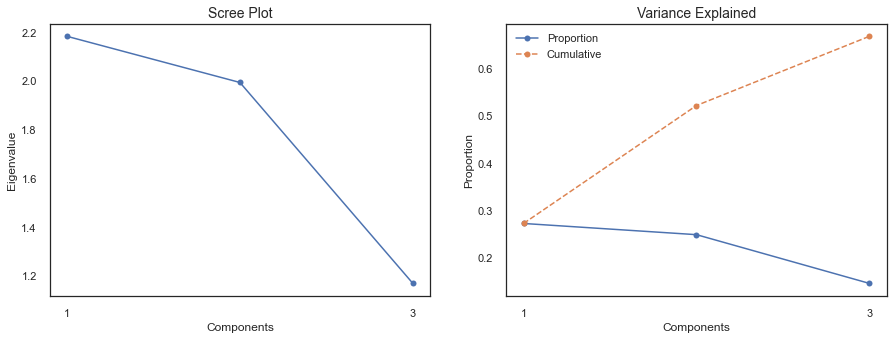

In [532]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [533]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=4)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3
0,-0.179018,-0.747969,-1.333249,0.330386
1,0.153015,-2.200641,0.923783,-0.533882
2,-0.228015,-0.192228,0.160133,-0.195561
3,0.122442,-1.283763,0.662203,-0.985023
4,0.095267,-0.573652,0.728228,-0.824178
...,...,...,...,...
10291,0.143805,1.199917,-0.562484,0.206411
10292,-0.653312,0.406122,0.864840,1.166956
10293,-0.261068,-0.071307,-1.265787,0.490801
10294,-0.069091,-0.690687,-0.527304,0.172067


In [534]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,EducDeg_Basic,EducDeg_High_School,EducDeg_PhD,Children_True,PC0,PC1,PC2,PC3
0,-0.282263,-1.353182,0.102820,-0.120022,-0.796412,-0.214005,0.0,1.0,0.0,1.0,-0.179018,-0.747969,-1.333249,0.330386
1,-1.570644,1.015440,-0.156389,0.126490,-1.542101,0.299838,0.0,1.0,0.0,1.0,0.153015,-2.200641,0.923783,-0.533882
2,-0.196371,0.225899,0.165433,-0.157167,-0.108084,-0.056879,1.0,0.0,0.0,0.0,-0.228015,-0.192228,0.160133,-0.195561
3,-1.208180,1.015440,-0.098615,0.082591,-0.739052,-0.349857,0.0,0.0,0.0,1.0,0.122442,-1.283763,0.662203,-0.985023
4,-0.637856,1.015440,-0.072183,0.052199,-0.280166,-0.290055,0.0,0.0,0.0,1.0,0.095267,-0.573652,0.728228,-0.824178


In [535]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3
MonthSal,0.020747,0.936730,0.044701,0.117242
GeoLivArea,0.014163,0.031702,0.887938,-0.458650
CustMonVal,-0.998158,0.019015,0.004105,-0.007869
ClaimsRate,0.997006,-0.031572,0.014282,0.039301
Age,0.020924,0.939858,0.029038,0.090958
Total_Prem,-0.052238,-0.208806,0.464265,0.859082


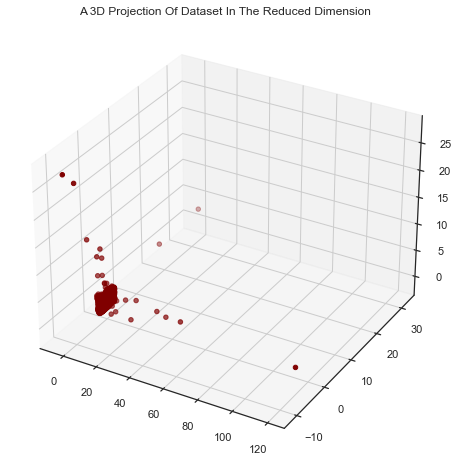

In [536]:
#A 3D Projection Of Data In The Reduced Dimension
x =df_pca["PC0"]
y =df_pca["PC1"]
z =df_pca["PC2"]
w =df_pca["PC3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o")
ax.set_title("A 3D Projection Of Dataset In The Reduced Dimension")
plt.show()

In [537]:
df5 = df_pca.copy()

In [538]:
df5.drop(columns=['PC3'], inplace=True)

In [539]:
## Rename OHE columns from "feature_val_a" to "x_feature_val_a"
## We do this to be able to distinguish the OHE columns more easily later

## Assemble OHE columns and their new column names
rename_ohe_cols = {}

for i in non_metric_features:
    for j in df5.columns[df5.columns.str.startswith(i)].to_list() :
        rename_ohe_cols[j] = 'x_' + j

df5.rename(columns=rename_ohe_cols, inplace=True)

In [540]:
df5.head(5)

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,x_EducDeg_Basic,x_EducDeg_High_School,x_EducDeg_PhD,x_Children_True,PC0,PC1,PC2
0,-0.282263,-1.353182,0.102820,-0.120022,-0.796412,-0.214005,0.0,1.0,0.0,1.0,-0.179018,-0.747969,-1.333249
1,-1.570644,1.015440,-0.156389,0.126490,-1.542101,0.299838,0.0,1.0,0.0,1.0,0.153015,-2.200641,0.923783
2,-0.196371,0.225899,0.165433,-0.157167,-0.108084,-0.056879,1.0,0.0,0.0,0.0,-0.228015,-0.192228,0.160133
3,-1.208180,1.015440,-0.098615,0.082591,-0.739052,-0.349857,0.0,0.0,0.0,1.0,0.122442,-1.283763,0.662203
4,-0.637856,1.015440,-0.072183,0.052199,-0.280166,-0.290055,0.0,0.0,0.0,1.0,0.095267,-0.573652,0.728228


In [552]:
df5.to_csv(os.path.join( "cluster_preprocessed.csv"), index=False)